In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle

In [3]:
def read_dataframe(filename):
    
    df = pd.read_parquet(filename)

    # Calculate trip duration in minutes

    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60) 

    # Keep only trips that at least 1 minute and at most 60

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    # Reduce dataset for perfomance. The model won't require so many data points

    df_sample = df.sample(frac=0.1)
    df_sample.shape

    # Features for modeling

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df_sample[categorical] = df_sample[categorical].astype(str)
    
    df_sample['PU_DO'] = df_sample['PULocationID'] + "_" + df_sample['DOLocationID']
    
    return df_sample

In [4]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet")

In [5]:
len(df_train), len(df_val)

(289891, 293806)

In [6]:
categorical = ['PU_DO'] # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

RMSE 5.6567027522837785


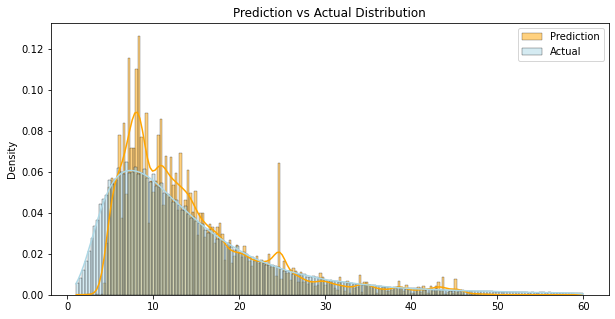

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print("RMSE", mean_squared_error(y_val, y_pred, squared=False))

plt.figure(figsize=(10,5))

sns.histplot(y_pred, color='orange', label='Prediction', kde=True, stat='density', alpha=0.5)
sns.histplot(y_train, color='lightblue', label='Actual', kde=True, stat='density', alpha=0.5)

plt.legend()
plt.title("Prediction vs Actual Distribution")
plt.show()

In [ ]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print("RMSE", mean_squared_error(y_val, y_pred, squared=False))

RMSE 9.555342905347318


RMSE 5.99099636723473


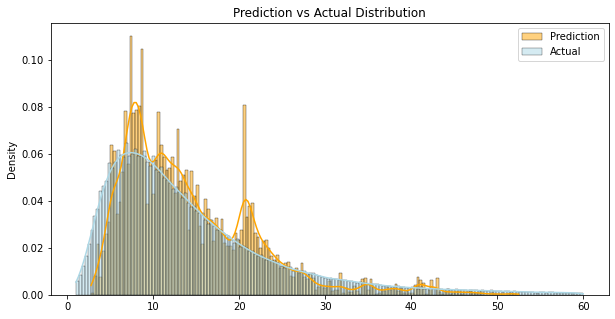

In [8]:
lr = Ridge(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

print("RMSE", mean_squared_error(y_val, y_pred, squared=False))

plt.figure(figsize=(10,5))

sns.histplot(y_pred, color='orange', label='Prediction', kde=True, stat='density', alpha=0.5)
sns.histplot(y_train, color='lightblue', label='Actual', kde=True, stat='density', alpha=0.5)

plt.legend()
plt.title("Prediction vs Actual Distribution")
plt.show()

In [ ]:
# Save model

with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)